In [24]:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
from gbm.finder import ContinuousFtp
from gbm.finder import TriggerFtp

# initialize the Trigger data finder with a trigger number
name = 'GRB230812B'
trignumber = '230812790'
trig_finder = TriggerFtp(trignumber)
print(trig_finder.num_files)

# initialize the continuous data finder with a time (Fermi MET, UTC, or GPS)
tburst = f"20{name[3:5]}-{name[5:7]}-{name[7:9]}T{timedelta(seconds=float(trignumber[6:9])/1000*24*3600)}"
print(f'Trigger time utc = {tburst}')
cont_finder = ContinuousFtp(utc=tburst)
print(cont_finder.num_files)

Connection appears to have failed.  Attempting to reconnect...
Reconnected.
128
Trigger time utc = 2023-08-12T18:57:36
Connection appears to have failed.  Attempting to reconnect...
Reconnected.
379


In [8]:
# uploading files
#trig_finder.get_tte(f'./GBM_Data/{name}')
#trig_finder.get_rsp(f'./GBM_Data/{name}', ctime=False)
#trig_finder.get_rsp2(f'./GBM_Data/{name}', ctime=False)
#cont_finder.get_poshist(f'./GBM_Data/{name}')

glg_poshist_all_230307_v01.fit [==============================] 100.00%


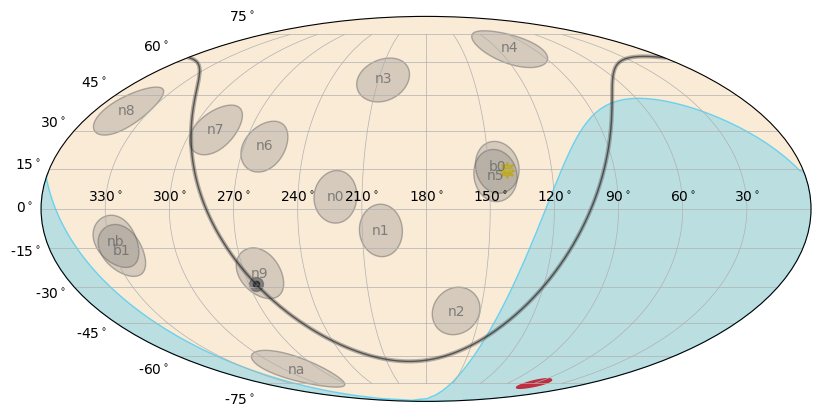

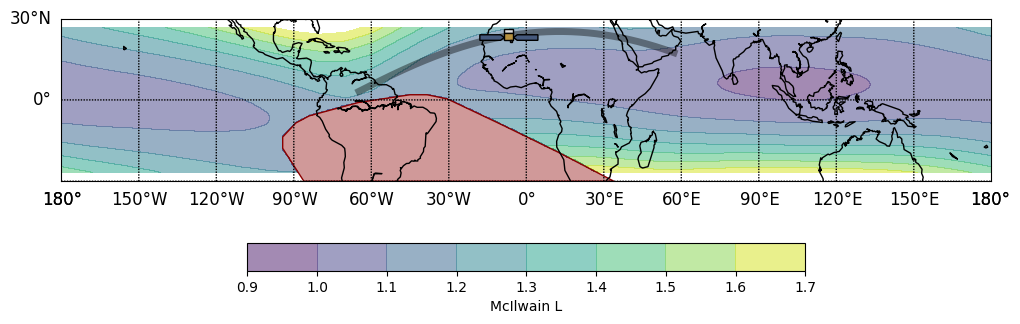

List of proper detectors = ['n3', 'n2', 'na', 'b1']
SAA = False


In [45]:
from gbm.data import PosHist
from gbm.time import Met
from gbm.plot import SkyPlot, FermiSkyPlot
from gbm.plot import EarthPlot
from gbm.plot.gbmplot import SkyCircle # plot element for plotting a (shaded) circle on the sky
"""
The derections of the detectors and position Fermi
"""
# location of the burst
ra = 59.233
dec = -75.226
radii = 3
v = '00'

poshist = PosHist.open(f'./GBM_Data/{name}/glg_poshist_all_{trignumber[0:6]}_v{v}.fit')
t0 = Met.from_iso(tburst).met

ls_detectors = ["n0", "n1","n2","n3","n4","n5","n6","n7","n8","n9","na","nb"]
# initialize plot
skyplot = SkyPlot()
_ = SkyCircle(ra, dec, radii, ax=skyplot.ax, color = "red")
# plot the orientation of the detectors and Earth blockage at our time of interest
skyplot.add_poshist(poshist, trigtime=t0)

#take the detectors which have angle <= 60
detectors = []
for d in ls_detectors:
    if poshist.detector_angle(ra, dec, d, t0) <= 60:
        detectors += [d]
if poshist.detector_angle(ra, dec, "b0", t0) <= poshist.detector_angle(ra, dec, "b1", t0):
    detectors += ["b0"]
else:
    detectors += ["b1"]

# initialize plot
earthplot = EarthPlot()

# let's show the orbital path for +/-1000 s around our t0
earthplot.add_poshist(poshist, trigtime=t0, time_range=(t0-1000.0, t0+1000.0))
plt.show()
print(f"List of proper detectors = {detectors}")
print(f'SAA = {poshist.get_saa_passage(t0)}')

In [46]:
from gbm.data import TTE, GbmDetectorCollection
from gbm.binning.unbinned import bin_by_time

v = "04"
tte_array = [TTE.open(f"./GBM_Data/{name}/glg_tte_{d}_bn{trignumber}_v{v}.fit") for d in detectors]
tte_collctn = GbmDetectorCollection.from_list(tte_array)

# bin TTE
# time_ref is the reference time for binning;
# if not set, it will bin starting at the beginning of the data
time_resolution = 1.024
time_range = (-100,400)
phaii_collctn = [det.to_phaii(bin_by_time, time_resolution, time_range=time_range, time_ref=0.0) for det in tte_collctn]
phaii_collctn = GbmDetectorCollection.from_list(phaii_collctn, dets=tte_collctn.detector())

In [47]:
# define enargy ranges
erange_nai = (8.0, 900.0) # range for NaI in kev
erange_bgo = (325, 35000.0) # range for Bgo

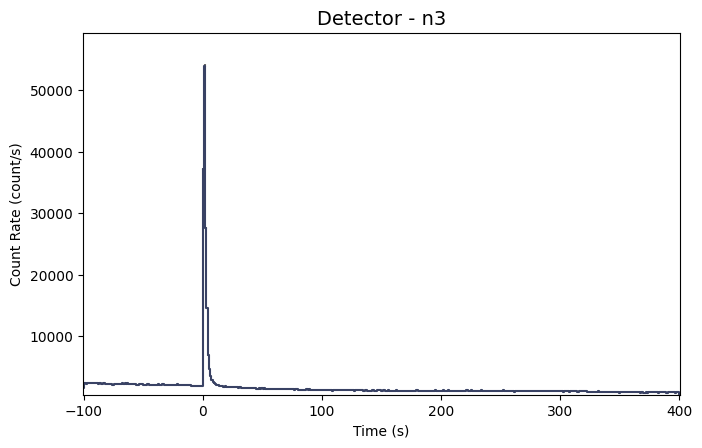

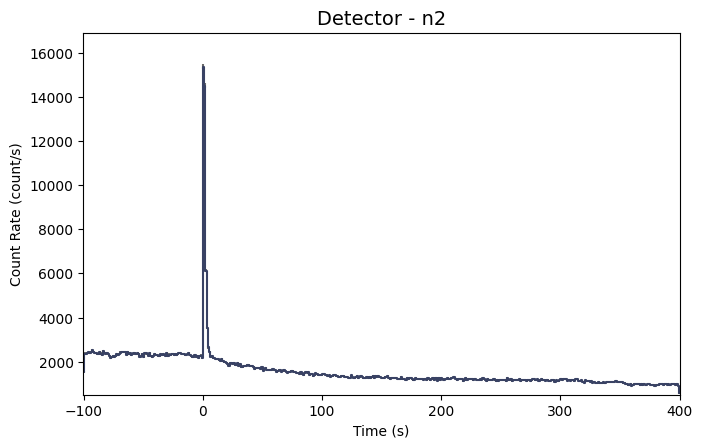

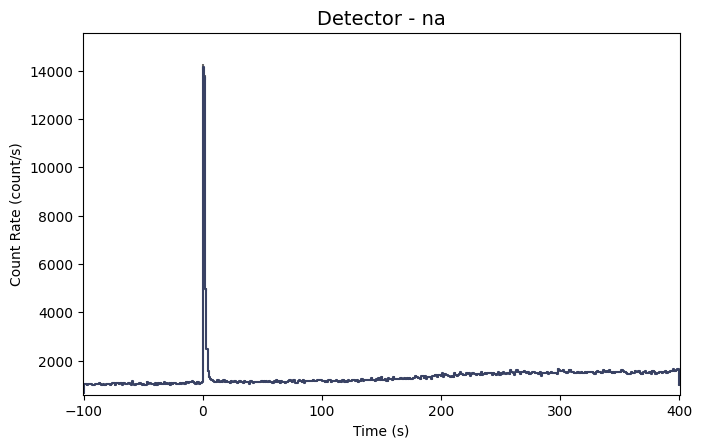

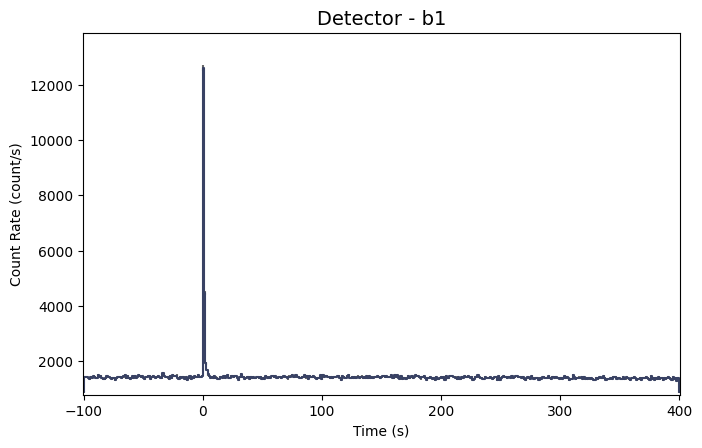

In [48]:
from gbm.plot import Spectrum
from gbm.plot import Lightcurve

# the lightcurves
data_lcs = phaii_collctn.to_lightcurve(nai_kwargs={'energy_range':erange_nai}, bgo_kwargs={'energy_range':erange_bgo})

# Ploting the preview lightcurves 
lcplots = [Lightcurve(data=data_lc) for data_lc in data_lcs]
#creating titles for plots
_ = [p.ax.set_title("Detector - "+title, fontsize = 14) for p, title in zip(lcplots, phaii_collctn.detector())]


In [49]:
from gbm.background import BackgroundFitter
from gbm.background.binned import Polynomial
"""
Fit and extrapolate background
"""
bkgd_range = [(-30., -10.), (30., 50.)] # the background fit ranges

# initialize the fitters and add to collection, making sure the collection knows which background
# goes with which detector
backfitters = [BackgroundFitter.from_phaii(detector_phaii, Polynomial, time_ranges=bkgd_range) for detector_phaii in phaii_collctn]
backfitters = GbmDetectorCollection.from_list(backfitters, dets=phaii_collctn.detector())


# do the fit with optimal order for each detectors
orders = []
for bfr, det in zip(backfitters, detectors):
    for n in range(1,4):
        bfr.fit(order=n)
        _chi2_dof = np.mean(bfr.statistic/bfr.dof)
        _error = np.mean(np.sqrt(2/bfr.dof))
        print(f'detector = {det}, n = {n}, chi2/dof_mean = {_chi2_dof}, sqrt(2/dof)_mean = {_error}')
        if _chi2_dof - _error <= 1 <= _chi2_dof + _error:
            orders += [n]
            break
            
    


[bfr.fit(order=n) for bfr, n in zip(backfitters, orders)]
print(f"Orders for the detectors:{np.array(orders)}")

# interpolate/extrapolate and store in a collection
bkgds = backfitters.interpolate_bins(phaii_collctn.data()[0].tstart, phaii_collctn.data()[0].tstop)
bkgds = GbmDetectorCollection.from_list(bkgds, dets=phaii_collctn.detector())


detector = n3, n = 1, chi2/dof_mean = 1.0141062201048672, sqrt(2/dof)_mean = 0.24186663297982725
detector = n2, n = 1, chi2/dof_mean = 0.9735253957330459, sqrt(2/dof)_mean = 0.24037065363477275
detector = na, n = 1, chi2/dof_mean = 0.9538466848386764, sqrt(2/dof)_mean = 0.23714428458210654
detector = b1, n = 1, chi2/dof_mean = 0.9259443756667468, sqrt(2/dof)_mean = 0.24189445741253987
Orders for the detectors:[1 1 1 1]


In [50]:
# the lightcurves
data_lcs = phaii_collctn.to_lightcurve(nai_kwargs={'energy_range':erange_nai}, bgo_kwargs={'energy_range':erange_bgo})
# the energy-integrated background
bkgd_lcs = bkgds.integrate_energy(nai_args=erange_nai, bgo_args=erange_bgo)

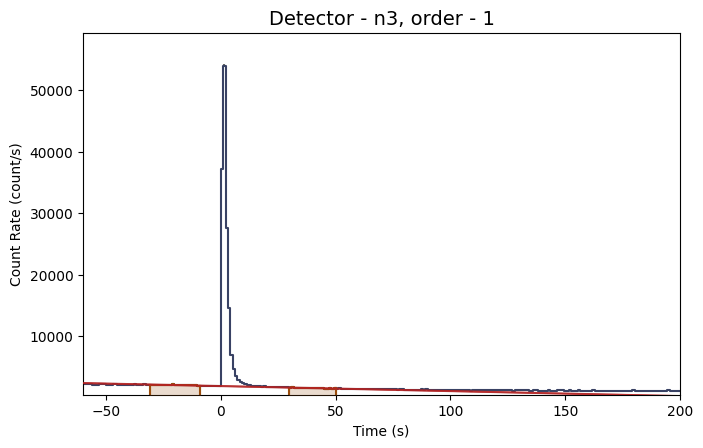

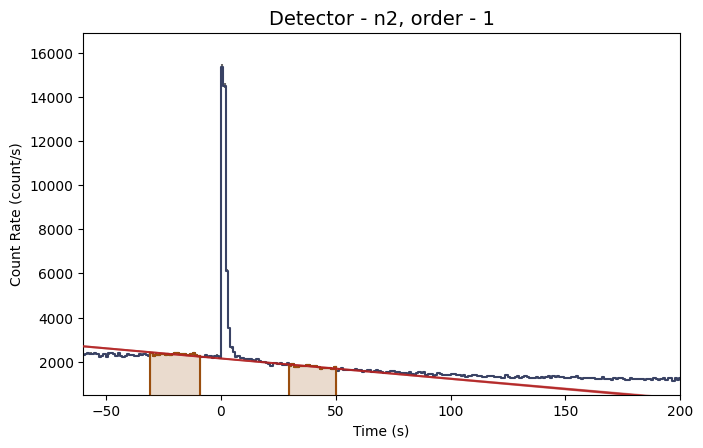

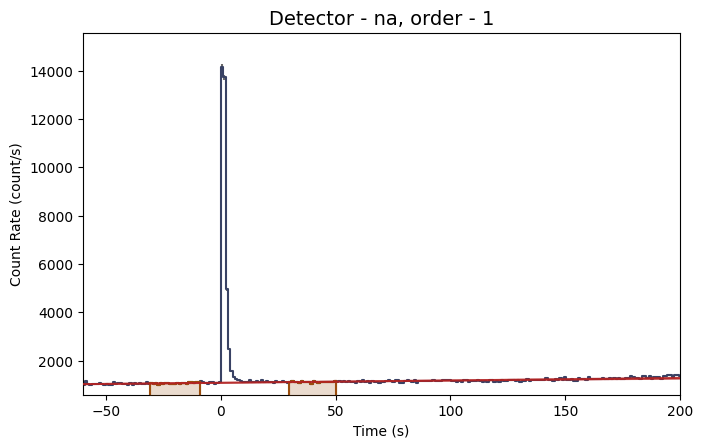

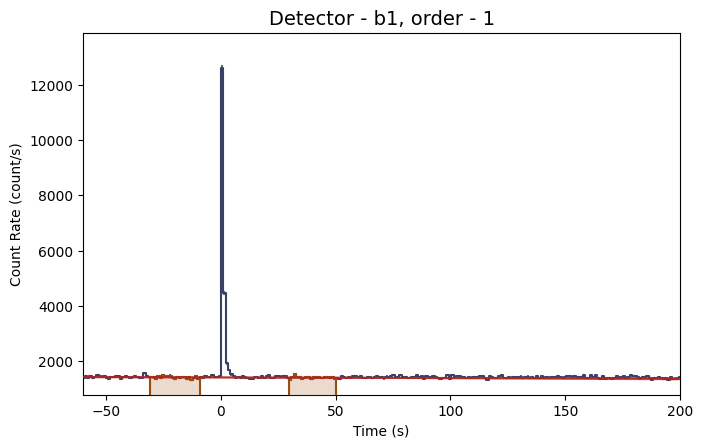

In [55]:
view_range = (-60,200)
# Plot the lightcurves with background fit
lcplots = [Lightcurve(data=data_lc, background=bkgd_lc) for data_lc, bkgd_lc in zip(data_lcs, bkgd_lcs)]

# background selection
back_selectin = [phaii_collctn.to_lightcurve(time_range=bkgd_time, nai_kwargs={'energy_range':erange_nai}, bgo_kwargs={'energy_range':erange_bgo}) for bkgd_time in bkgd_range]
for bs in back_selectin:
    _ = [lcplot.add_selection(src_lc) for lcplot, src_lc in zip(lcplots, bs)]
    
#titles for plots
_ = [p.ax.set_title(f"Detector - {title}, order - {o}", fontsize = 14) for p, title, o in zip(lcplots, phaii_collctn.detector(), np.array(orders))]

for lcplot in lcplots:
    lcplot.xlim = view_range

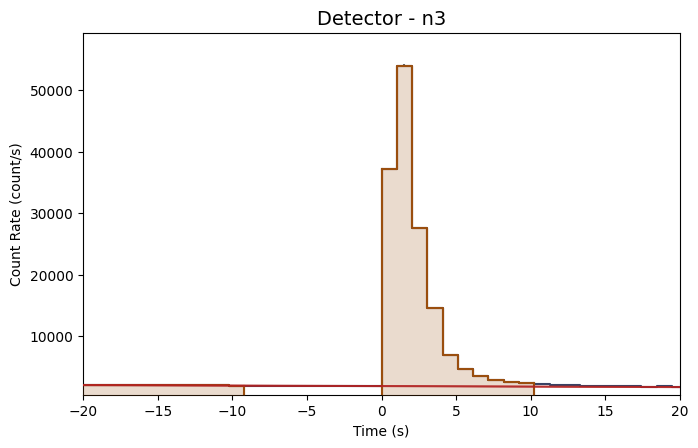

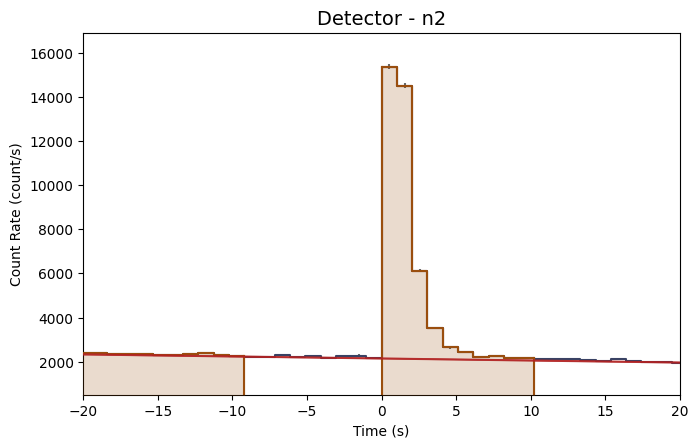

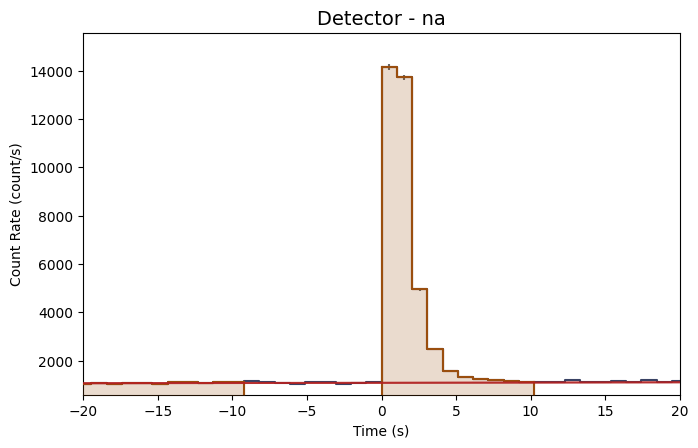

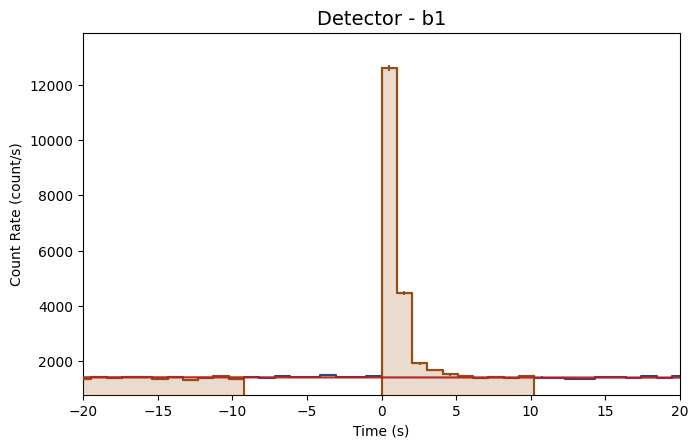

In [54]:
src_range = (0, 10)    # the burst duration
view_range = (-20, 20.0) # zoom in to this time range
# the source time selection
src_lcs = phaii_collctn.to_lightcurve(time_range=src_range, nai_kwargs={'energy_range':erange_nai}, bgo_kwargs={'energy_range':erange_bgo})
# the energy selection
src_specs = phaii_collctn.to_spectrum(time_range=src_range, nai_kwargs={'energy_range':erange_nai}, bgo_kwargs={'energy_range':erange_bgo})

# Plot the lightcurves with the selections and background fit
lcplots = [Lightcurve(data=data_lc, background=bkgd_lc) for data_lc, bkgd_lc in zip(data_lcs, bkgd_lcs)]
_ = [lcplot.add_selection(src_lc) for lcplot, src_lc in zip(lcplots, src_lcs)]
# background selection
back_selectin = [phaii_collctn.to_lightcurve(time_range=bkgd_time, nai_kwargs={'energy_range':erange_nai}, bgo_kwargs={'energy_range':erange_bgo}) for bkgd_time in bkgd_range]
for bs in back_selectin:
    _ = [lcplot.add_selection(src_lc) for lcplot, src_lc in zip(lcplots, bs)]
    
#titles for plots
_ = [p.ax.set_title("Detector - "+title, fontsize = 14) for p, title in zip(lcplots, phaii_collctn.detector())]
# zoom in
for lcplot in lcplots:
    lcplot.xlim = view_range
plt.show()

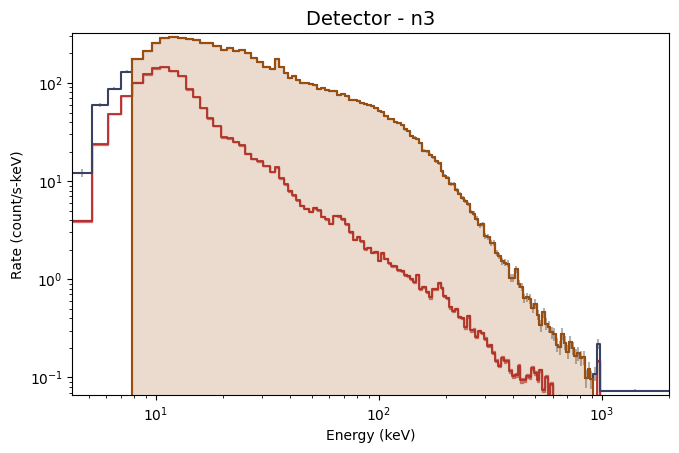

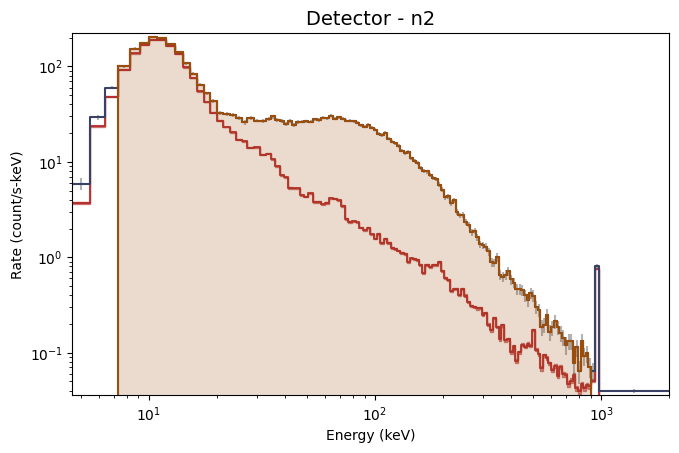

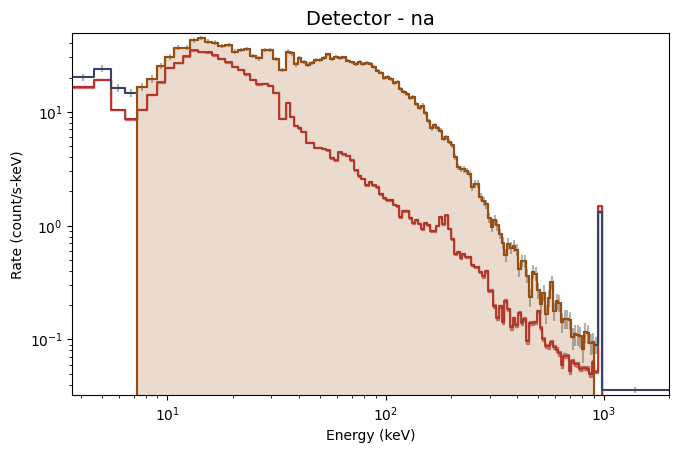

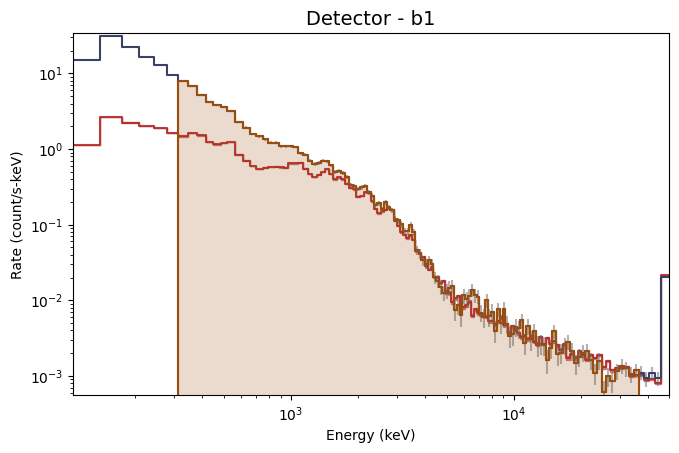

In [56]:
# the count spectrum
data_specs = phaii_collctn.to_spectrum(time_range=src_range)
# the time-integrated background
bkgd_specs = bkgds.integrate_time(*src_range)

# Plot the spectra with the selections and background fit
specplots = [Spectrum(data=data_spec, background=bkgd_spec) for data_spec, bkgd_spec in zip(data_specs, bkgd_specs)]
_ = [specplot.add_selection(src_spec) for specplot, src_spec in zip(specplots, src_specs)]

#titles for plots
_ = [p.ax.set_title("Detector - "+title, fontsize = 14) for p, title in zip(specplots, phaii_collctn.detector())]

In [57]:
#this can be saved as objects .pha and .bak
phas = phaii_collctn.to_pha(time_ranges=src_range, nai_kwargs={'energy_range':erange_nai}, bgo_kwargs={'energy_range':erange_bgo})
# the background spectrum
baks = bkgds.to_bak(time_range=src_range)


In [58]:
from gbm.data import RSP
# open responses
v = "02"
rsp_array = [RSP.open(f'./GBM_Data/{name}/glg_cspec_{d}_bn{trignumber}_v{v}.rsp2') for d in detectors]
rsps = GbmDetectorCollection.from_list(rsp_array)

# and interpolate response files to get DRMs at center of the source window
rsps_interp = [rsp.interpolate(pha.tcent) for rsp, pha in zip(rsps, phas)]

In [62]:
#writting
"""
namesfiles = [f'custom_cspec_{d}_{trignumber}' for d in phaii_collctn.detector()]
[rsp.write(f'./GBM_Data/{name}', filename=n+".rsp") for rsp, n in zip(rsps_interp, namesfiles)]
[bak.write(f'./GBM_Data/{name}', filename=n+".bak") for bak, n in zip(baks, namesfiles)]
[pha.write(f'./GBM_Data/{name}', filename=n+".pha", backfile=n+".bak") for pha, n in zip(phas, namesfiles)]
"""

'\nnamesfiles = [f\'custom_cspec_{d}_{trignumber}\' for d in phaii_collctn.detector()]\n[rsp.write(f\'./GBM_Data/{name}\', filename=n+".rsp") for rsp, n in zip(rsps_interp, namesfiles)]\n[bak.write(f\'./GBM_Data/{name}\', filename=n+".bak") for bak, n in zip(baks, namesfiles)]\n[pha.write(f\'./GBM_Data/{name}\', filename=n+".pha", backfile=n+".bak") for pha, n in zip(phas, namesfiles)]\n'